In [1]:
import os
import re
from multiprocessing import Pool

import pandas as pd


In [2]:
# replace all cells without numbers with NA
def replace_non_digit_string(data_frame):
    mask = ~data_frame[['Salary', 'BirthDate', 'Time']].apply(lambda col: col.astype(str).str.contains(r'\d')).any(axis=1)
    data_frame.loc[mask, ['Name', 'BirthDate', 'Time']] = pd.NA
    return data_frame


In [3]:
# remove all empty strings
def remove_empty_strings(data_frame):
    data_frame = data_frame.dropna(how='all')
    return data_frame


In [4]:
# remove all duplicates
def remove_duplicates(date_frame):
    date_frame = date_frame.drop_duplicates()
    return date_frame


In [5]:
# delete all lines between 1:00:00 and 3:00:00
def remove_by_time(data_frame):
    start_time = pd.to_datetime('01:00:00').time()
    end_time = pd.to_datetime('03:00:00').time()

    data_frame['Time'] = pd.to_datetime(data_frame['Time'], format='%H:%M:%S', errors='coerce').dt.time

    mask = (data_frame['Time'].notna()) & (data_frame['Time'] > start_time) & (data_frame['Time'] < end_time)
    data_frame.loc[mask, ['Name', 'BirthDate', 'Time']] = pd.NA
    return data_frame


In [6]:
df = pd.read_csv('.test_data_set.csv')
# df = pd.read_csv('test.csv')

df.fillna('')

df = replace_non_digit_string(df)   
df = remove_empty_strings(df)
df = remove_duplicates(df)
df = remove_by_time(df)


In [7]:
# get unique rows for every hour, get median values and mean values
def metrics_calculation(data_frame):
    data_frame['Time'] = pd.to_datetime(data_frame['Time'], format='%H:%M:%S').dt.time
    
    data_frame['Hour'] = pd.to_datetime(data_frame['Time'].astype(str), format='%H:%M:%S').dt.hour
   
    grouped = data_frame.groupby('Hour')

    unique_counts = grouped['Name'].nunique()
    mean_values = grouped['Salary'].mean()
    median_values = grouped['Salary'].median()

    result = pd.DataFrame({
        'UniqueCounts': unique_counts,
        'MeanValues': mean_values,
        'MedianValues': median_values
    })

    return result




In [8]:
metrics = metrics_calculation(df)
merged_data_frame = pd.merge(df, metrics, on='Hour', how='outer')

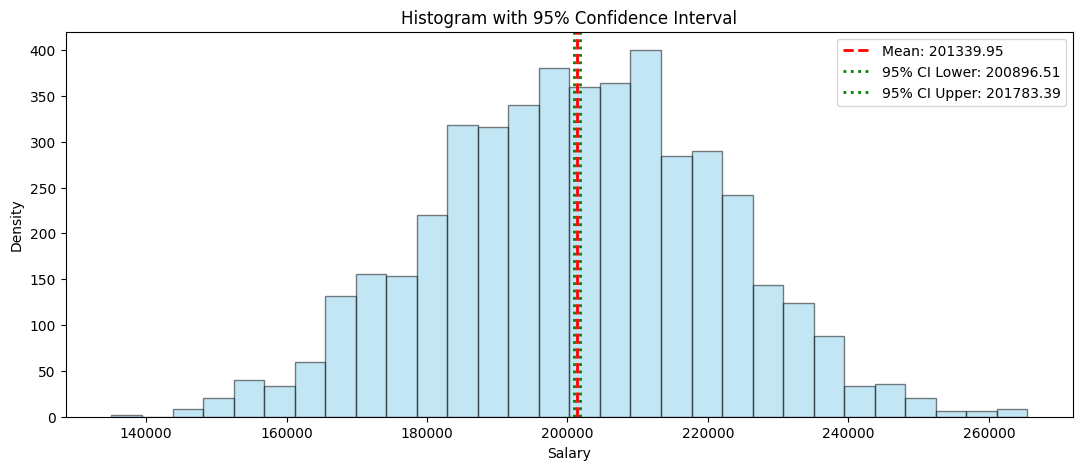

In [9]:
'''
Having a large sample and normal distribution of data, 
I calculated a confidence interval based on the sample - I used the z-distribution.
'''

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats 

sample = df['Salary']

# calculate mean and standart deviation
mean = np.mean(sample)
std_dev = np.std(sample, ddof=1)
n = len(sample)

# calculate of 95% confidience interval
confidience_level = 0.95
Z = stats.norm.ppf((1 + confidience_level)/2)

# formula for confidience interval
margin_of_error = Z * (std_dev / np.sqrt(n))
confidience_interval = (mean - margin_of_error, mean + margin_of_error)

plt.figure(figsize=(13, 5))

plt.hist(sample, bins=30, color='skyblue', alpha=0.5, edgecolor='black')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(confidience_interval[0], color='green', linestyle='dotted', linewidth=2, label=f'95% CI Lower: {confidience_interval[0]:.2f}')
plt.axvline(confidience_interval[1], color='green', linestyle='dotted', linewidth=2, label=f'95% CI Upper: {confidience_interval[1]:.2f}')
plt.title('Histogram with 95% Confidence Interval')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.legend()
plt.show()

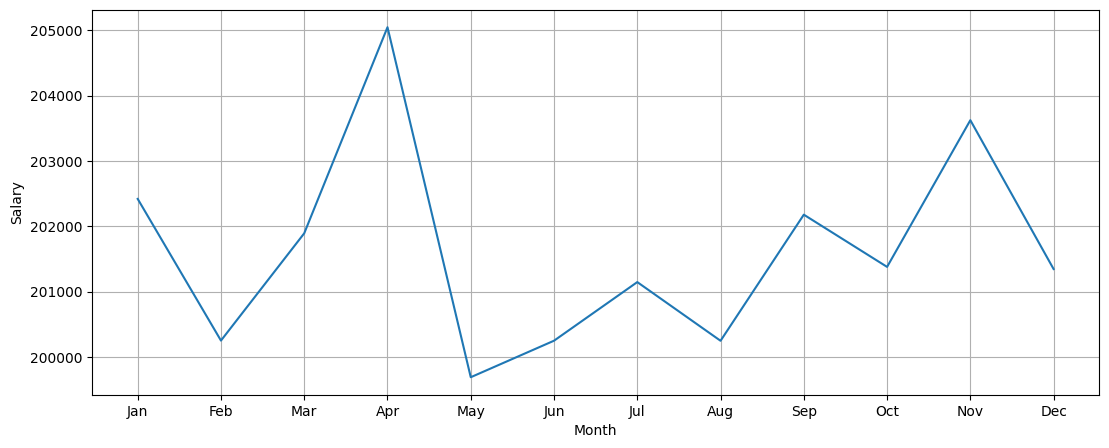

In [10]:
import  matplotlib.pyplot as plt
import calendar

df['BirthDate'] = pd.to_datetime(df['BirthDate'])
df['month'] = df['BirthDate'].dt.month
monthly_mean = df.groupby('month')['Salary'].mean()

monthly_mean.index = [calendar.month_abbr[int(month)] for month in monthly_mean.index]

plt.figure(figsize=(13, 5))

plt.plot(monthly_mean.index, monthly_mean.values)
plt.xlabel('Month')
plt.ylabel('Salary')
plt.grid(True)
plt.show()
